# Imports

In [10]:
"""
Section 4: PyTorch Neural Network Classification
"""
import torch
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as panda
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt

torch.__version__

'1.13.1'

# Make a toy dataset

In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
circles = panda.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


## plot the dataset

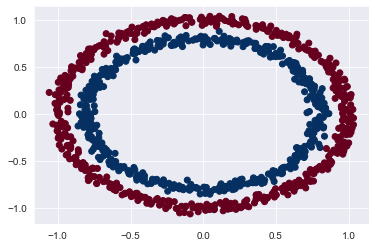

In [7]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdBu)
plt.show()

## convert from numpy to torch.tensor

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Split between test & train

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Create the model

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self ,x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Create a nn.sequential

In [14]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0399, -0.1185],
                      [-0.6297, -0.2341],
                      [-0.5393,  0.3765],
                      [-0.0371, -0.0033],
                      [ 0.1776,  0.6023]])),
             ('0.bias', tensor([ 0.6167,  0.3410,  0.4990, -0.6872,  0.0282])),
             ('1.weight',
              tensor([[-0.1721, -0.2340, -0.2371, -0.3377, -0.3029]])),
             ('1.bias', tensor([0.0679]))])

In [16]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2315],
        [-0.1970],
        [-0.1109],
        [-0.2665],
        [ 0.2239],
        [ 0.2424],
        [ 0.0741],
        [ 0.1778],
        [-0.1252],
        [-0.1910]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Set up a loss function & optimizer

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [ ]:
def accuracy_fn(y_true, y_predicted):
    correct = torch.eq(y_true, y_predicted).sum().item()
    accuracy = (correct / len(y_predicted)) * 100
    return accuracy

In [18]:
# The logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2315],
        [-0.1970],
        [-0.1109],
        [-0.2665],
        [ 0.2239]])

In [19]:
# prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4424],
        [0.4509],
        [0.4723],
        [0.4338],
        [0.5557]])

In [20]:
# predicted labels
y_preds = torch.round(y_pred_probs)

# logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]])

# Build a training & testing loop

In [ ]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_train.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    # logits -> predicted probabilities -> prediction labels
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    # calculate loss & accuracy, nn.BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_predicted=y_pred)

    # 3. Zero out the gradients
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimization (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_predictions = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_predicted=test_predictions)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}\n | Loss: {loss}, Accuracy: {acc:.2f}%"
              f"\n | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")